In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import numpy as np
import pandas as pd 
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, LSTM,Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
TRAIN_DATA_FILE = 'train.csv.zip'
TEST_DATA_FILE = 'new_test.csv'

In [4]:
MAX_LEN = 60
MAX_NUM_WORDS = 200000  
EMBEDDING_DIM = 300 
VALIDATION_SPLIT_RATE = 0.1 
HIDDEN_SIZE = 180 
DENSE_SIZE = 128  
DROPOUT_RATE_LSTM = 0.1655 
DROUPOUT_RATE_DENSE = 0.2939  
ACTIVATION_FUNCTION = 'relu'

In [5]:
def text_to_wordlist(sentence):
    
    sentence = sentence.lower().split()
    sentence = " ".join(sentence)

    sentence = re.sub(r"coronavirus", "corona virus 2019", sentence)
    sentence = re.sub(r"covid-19", "corona virus 2019", sentence)
    sentence = re.sub(r"covid - 19", "corona virus 2019", sentence)
    sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", sentence)
    sentence = re.sub(r"what's", "what is ", sentence)
    sentence = re.sub(r"\'s", " ", sentence)
    sentence = re.sub(r"\'ve", " have ", sentence)
    sentence = re.sub(r"can't", "cannot ", sentence)
    sentence = re.sub(r"n't", " not ", sentence)
    sentence = re.sub(r"i'm", "i am ", sentence)
    sentence = re.sub(r"\'re", " are ", sentence)
    sentence = re.sub(r"\'d", " would ", sentence)
    sentence = re.sub(r"\'ll", " will ", sentence)
    sentence = re.sub(r",", " ", sentence)
    sentence = re.sub(r"\.", " ", sentence)
    sentence = re.sub(r"!", " ! ", sentence)
    sentence = re.sub(r"\/", " ", sentence)
    sentence = re.sub(r"\^", " ^ ", sentence)
    sentence = re.sub(r"\+", " + ", sentence)
    sentence = re.sub(r"\-", " - ", sentence)
    sentence = re.sub(r"\=", " = ", sentence)
    sentence = re.sub(r"'", " ", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r"(\d+)(k)", r"\g<1>000", sentence)
    sentence = re.sub(r" e g ", " eg ", sentence)
    sentence = re.sub(r" b g ", " bg ", sentence)
    sentence = re.sub(r" u s ", " american ", sentence)
    sentence = re.sub(r" 9 11 ", "911", sentence)
    sentence = re.sub(r"e - mail", "email", sentence)
    sentence = re.sub(r"j k", "jk", sentence)
    sentence = re.sub(r"\s{2,}", " ", sentence)
    
    return sentence


In [6]:
embeddings_index = {}
f = open(EMBEDDING_FILE, encoding='utf-8')
for line in f:  
    values = line.split()
    word = ''.join(values[:-300])
    embeddings_index[word] = np.asarray(values[-300:], dtype='float32')
f.close()

In [7]:
train_ques_1 = list()  
train_ques_2 = list()  

df_train = pd.read_csv(TRAIN_DATA_FILE, encoding='utf-8')
df_train = df_train.fillna('empty')
train_labels = df_train.is_duplicate.values

for text in df_train.question1.values:
    train_ques_1.append(text_to_wordlist(text))
    
for text in df_train.question2.values:
    train_ques_2.append(text_to_wordlist(text))

print('{} words in train file'.format(len(train_ques_1)))

404280 words in train file


In [9]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
test_ques_1 = list()  
test_ques_2 = list()  

df_test = pd.read_csv(TEST_DATA_FILE, encoding='utf-8')  #read only 500 items
df_test = df_test.fillna('empty')
# test_ids = df_test.test_id.values
test_ids = df_test.test_id.values  

for text in df_test.question1.values:
    test_ques_1.append(text_to_wordlist(text))
    
for text in df_test.question2.values:
    test_ques_2.append(text_to_wordlist(text))
    
print('{} words in test file'.format(len(test_ques_1)))

501 words in test file


In [13]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [14]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_ques_1 + train_ques_2 + test_ques_1 + test_ques_2 )   #fit each words to the tokenizer

In [15]:
#convert each word into corresponding sequence
train_ques_1 = tokenizer.texts_to_sequences(train_ques_1)  
train_ques_2 = tokenizer.texts_to_sequences(train_ques_2)  
test_ques_1 = tokenizer.texts_to_sequences(test_ques_1)  
test_ques_2 = tokenizer.texts_to_sequences(test_ques_2)  


In [16]:
word_index = tokenizer.word_index
print('{} unique words/tokens present'.format(len(word_index)))

85569 unique words/tokens present


In [17]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index

In [18]:
train_ques_1 = pad_sequences(train_ques_1, maxlen=MAX_LEN)
train_ques_2 = pad_sequences(train_ques_2, maxlen=MAX_LEN)
print('Shape of train data tensor:', train_ques_1.shape)
print('Shape of train labels tensor:', train_labels.shape)

Shape of train data tensor: (404280, 60)
Shape of train labels tensor: (404280,)


In [19]:
test_ques_1 = pad_sequences(test_ques_1, maxlen=MAX_LEN)
test_ques_2 = pad_sequences(test_ques_2, maxlen=MAX_LEN)
print('Shape of test data vtensor:', test_ques_1.shape)
print('Shape of test ids tensor:', test_ids.shape)


Shape of test data vtensor: (501, 60)
Shape of test ids tensor: (501,)


In [20]:
questions = pd.concat([df_train[['question1', 'question2']], df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
question_dict = defaultdict(set)
for i in range(questions.shape[0]):
        question_dict[questions.question1[i]].add(questions.question2[i])
        question_dict[questions.question2[i]].add(questions.question1[i])

In [21]:
len(question_dict)

538300

In [22]:
# saving
with open('q_dict.pickle', 'wb') as handle:
    pickle.dump(question_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
df_train['q1_q2_intersect'] = df_train.apply(lambda row : len(set(question_dict[row[3]]).intersection(set(question_dict[row[4]]))) , axis=1, raw=True)
df_train['ques1_freq'] = df_train.apply(lambda row: len(question_dict.get(row[3])) , axis=1, raw=True)
df_train['ques2_freq'] = df_train.apply(lambda row: len(question_dict.get(row[4])), axis=1, raw=True)

In [24]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_q2_intersect,ques1_freq,ques2_freq
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,4,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,3,1


In [15]:
# df_test['q1_q2_intersect'] = df_test.apply(lambda row : len(set(question_dict[row[3]]).intersection(set(question_dict[row[4]]))) , axis=1, raw=True)
# df_test['ques1_freq'] = df_test.apply(lambda row: len(question_dict.get(row[3])) , axis=1, raw=True)
# df_test['ques2_freq'] = df_test.apply(lambda row: len(question_dict.get(row[4])), axis=1, raw=True)

In [26]:
df_test['q1_q2_intersect'] = df_test.apply(lambda row: len(set(question_dict.get(row[1])).intersection(set(question_dict.get(row[2])))), axis=1, raw=True)
df_test['ques1_freq'] = df_test.apply(lambda row: len(question_dict.get(row[1])), axis=1, raw=True)
df_test['ques2_freq'] = df_test.apply(lambda row: len(question_dict.get(row[2])), axis=1, raw=True)

In [27]:
df_test.head()

,test_id,question1,question2,q1_q2_intersect,ques1_freq,ques2_freq
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0,1,1
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0,1,1
2,2,What but is the best way to send money from Ch...,What you send money to China?,0,1,1
3,3,Which food not emulsifiers?,What foods fibre?,0,1,1
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0,1,1


In [29]:
train_data_features = pd.read_csv('Feature Engineering/Train/feature_nlp+tm.csv')
train_data_features = train_data_features.fillna(0)

test_data_features = pd.read_csv('Feature Engineering/Test/feature_tm+nlp_test.csv')

print('Features(nlp&tm) Loaded')
print(len(df_train))
print(len(df_test))
print(len(train_data_features))
print(len(test_data_features))
#print(len(df_feature_val))

Features(nlp&tm) Loaded
404280
501
404290
501


In [30]:
train_data_features.head()

,id,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,66,57,9,14,12,2,1,1,0,53,46,7,3.785714,3.833333,-0.047619,10.0,23.0,0.434783,0.416667,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1.216034,0.031762,14.274065,91.483062,1.047253,1.047253
1,1,51,88,-37,8,13,-5,5,5,0,44,76,-32,5.500000,5.846154,-0.346154,4.0,20.0,0.200000,0.052632,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4.897662,0.266555,33.272633,149.670092,2.624989,2.624989
2,2,73,59,14,14,10,4,5,5,0,60,50,10,4.285714,5.000000,-0.714286,4.0,24.0,0.166667,0.045455,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,4.011556,0.118900,28.457512,129.214660,2.140298,2.140298
3,3,50,65,-15,11,9,2,4,1,3,40,57,-17,3.636364,6.333333,-2.696970,0.0,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,7.514702,0.619671,62.016426,200.899534,4.702347,4.702347
4,4,76,39,37,13,7,6,1,1,0,64,33,31,4.923077,4.714286,0.208791,2.0,20.0,0.100000,0.000000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,6.257260,0.244168,40.127296,156.627744,3.145122,3.145122


In [31]:
test_data_features.head()

,test_id,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,57,68,-11,11,14,-3,5,4,1,47,55,-8,4.272727,3.928571,0.344156,2.0,24.0,0.083333,0.043478,0.599988,0.333330,0.000000,0.000000,0.272725,0.214284,0,0,3,12.5,54,50,37,45,0.241379,5.377619,0.212743,32.914707,158.719900,2.450075,2.450075
1,1,66,43,23,14,7,7,3,1,2,53,37,16,3.785714,5.285714,-1.500000,4.0,21.0,0.190476,0.105263,0.799984,0.571420,0.499975,0.142855,0.714276,0.357140,0,0,7,10.5,82,58,47,56,0.386364,2.885574,0.082187,22.012440,127.354115,1.689144,1.689144
2,2,60,29,31,14,6,8,4,2,2,47,24,23,3.357143,4.000000,-0.642857,4.0,18.0,0.222222,0.055556,0.999967,0.499992,0.666644,0.333328,0.833319,0.357140,0,1,8,10.0,92,55,57,83,0.400000,3.004117,0.094164,26.997807,123.466020,1.951432,1.951432
3,3,27,17,10,4,3,1,1,1,0,24,15,9,6.000000,5.000000,1.000000,0.0,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,3.5,52,52,52,53,0.277778,7.164147,0.391609,73.987938,177.060048,5.201015,5.201015
4,4,32,30,2,4,6,-2,1,2,-1,29,25,4,7.250000,4.166667,3.083333,3.0,10.0,0.300000,0.125000,0.999950,0.666644,0.999900,0.249994,0.749981,0.499992,1,1,2,5.0,74,66,70,73,0.483871,3.298204,0.247688,40.107086,147.543857,3.130887,3.130887


In [32]:
df_train['id'] = train_data_features['id']
df_test['test_id'] = test_data_features['test_id']


df_train = df_train.merge(train_data_features, on='id', how='left')
leak = df_train.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1)
df_test = df_test.merge(test_data_features, on='test_id', how='left')
test_leak = df_test.drop(['test_id','question1','question2'], axis=1)
print('Features created')

Features created


In [33]:
leak.head()

,q1_q2_intersect,ques1_freq,ques2_freq,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,1,1,66,57,9,14,12,2,1,1,0,53,46,7,3.785714,3.833333,-0.047619,10.0,23.0,0.434783,0.416667,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1.216034,0.031762,14.274065,91.483062,1.047253,1.047253
1,0,4,2,51,88,-37,8,13,-5,5,5,0,44,76,-32,5.500000,5.846154,-0.346154,4.0,20.0,0.200000,0.052632,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4.897662,0.266555,33.272633,149.670092,2.624989,2.624989
2,0,1,1,73,59,14,14,10,4,5,5,0,60,50,10,4.285714,5.000000,-0.714286,4.0,24.0,0.166667,0.045455,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,4.011556,0.118900,28.457512,129.214660,2.140298,2.140298
3,0,1,1,50,65,-15,11,9,2,4,1,3,40,57,-17,3.636364,6.333333,-2.696970,0.0,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,7.514702,0.619671,62.016426,200.899534,4.702347,4.702347
4,0,3,1,76,39,37,13,7,6,1,1,0,64,33,31,4.923077,4.714286,0.208791,2.0,20.0,0.100000,0.000000,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,6.257260,0.244168,40.127296,156.627744,3.145122,3.145122


In [34]:
test_leak.head()

,q1_q2_intersect,ques1_freq,ques2_freq,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,1,1,57,68,-11,11,14,-3,5,4,1,47,55,-8,4.272727,3.928571,0.344156,2.0,24.0,0.083333,0.043478,0.599988,0.333330,0.000000,0.000000,0.272725,0.214284,0,0,3,12.5,54,50,37,45,0.241379,5.377619,0.212743,32.914707,158.719900,2.450075,2.450075
1,0,1,1,66,43,23,14,7,7,3,1,2,53,37,16,3.785714,5.285714,-1.500000,4.0,21.0,0.190476,0.105263,0.799984,0.571420,0.499975,0.142855,0.714276,0.357140,0,0,7,10.5,82,58,47,56,0.386364,2.885574,0.082187,22.012440,127.354115,1.689144,1.689144
2,0,1,1,60,29,31,14,6,8,4,2,2,47,24,23,3.357143,4.000000,-0.642857,4.0,18.0,0.222222,0.055556,0.999967,0.499992,0.666644,0.333328,0.833319,0.357140,0,1,8,10.0,92,55,57,83,0.400000,3.004117,0.094164,26.997807,123.466020,1.951432,1.951432
3,0,1,1,27,17,10,4,3,1,1,1,0,24,15,9,6.000000,5.000000,1.000000,0.0,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,3.5,52,52,52,53,0.277778,7.164147,0.391609,73.987938,177.060048,5.201015,5.201015
4,0,1,1,32,30,2,4,6,-2,1,2,-1,29,25,4,7.250000,4.166667,3.083333,3.0,10.0,0.300000,0.125000,0.999950,0.666644,0.999900,0.249994,0.749981,0.499992,1,1,2,5.0,74,66,70,73,0.483871,3.298204,0.247688,40.107086,147.543857,3.130887,3.130887


In [35]:
ss = StandardScaler()
ss.fit(np.vstack((leak, test_leak)))
leaks = ss.transform(leak)  
test_leaks = ss.transform(test_leak) 
print('Normalization finished')

Normalization finished


In [36]:
with open('ss.pickle', 'wb') as handle:
    pickle.dump(ss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
random_numbers = np.random.permutation(len(train_ques_1))
train_question_indices = random_numbers[:int(len(train_ques_1) * (1 - VALIDATION_SPLIT_RATE))]
test_question_indices = random_numbers[int(len(train_ques_1) * (1 - VALIDATION_SPLIT_RATE)):]
print(train_question_indices)
print(test_question_indices)

[232335 249416 249049 ... 102472 144122  61422]
[105299 285844  13867 ... 149653 103308  91534]


In [38]:
data_1_train = np.vstack((train_ques_1[train_question_indices], train_ques_2[train_question_indices]))
data_2_train = np.vstack((train_ques_2[train_question_indices], train_ques_1[train_question_indices]))
leaks_train = np.vstack((leaks[train_question_indices], leaks[train_question_indices]))
labels_train = np.concatenate((train_labels[train_question_indices], train_labels[train_question_indices]))

In [39]:
data_1_val = np.vstack((train_ques_1[test_question_indices], train_ques_2[test_question_indices]))
data_2_val = np.vstack((train_ques_2[test_question_indices], train_ques_1[test_question_indices]))
leaks_val = np.vstack((leaks[test_question_indices], leaks[test_question_indices]))
labels_val = np.concatenate((train_labels[test_question_indices], train_labels[test_question_indices]))

In [ ]:
# weight_val = np.ones(len(labels_val))
# weight_val *= 0.5
# weight_val[labels_val==0] = 1.4

In [40]:
from keras.layers import Bidirectional

In [41]:
print('Preparing embedding matrix')

num_words = min(MAX_NUM_WORDS, len(word_index))+1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))  
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix


In [42]:
#creating embedding layer
emb_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
)  


In [43]:

#creating bilstm layer
lstm_layer = Bidirectional(LSTM(HIDDEN_SIZE, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM))

In [44]:
#take questions as input
seq1 = Input(shape=(MAX_LEN,), dtype='int32')
seq2 = Input(shape=(MAX_LEN,), dtype='int32')

In [45]:
#attach embedding layer to the model
emb1 = emb_layer(seq1)
emb2 = emb_layer(seq2)

In [46]:
#attach cnn layer to the model
cnn_a = Conv1D(filters=32, kernel_size=8,activation='relu')(emb1)
cnn_b = Conv1D(filters=32, kernel_size=8,activation='relu')(emb2)
cnn_a = GlobalMaxPooling1D()(cnn_a)
cnn_b = GlobalMaxPooling1D()(cnn_b)
cnn_con = concatenate([cnn_a,cnn_b])
cnn_con = BatchNormalization()(cnn_con)
cnn_con = Dropout(DROUPOUT_RATE_DENSE)(cnn_con)
cnn_con = Dense(int(DENSE_SIZE), activation=ACTIVATION_FUNCTION)(cnn_con)

In [47]:
#attach bilstm layer to the model
lstm_a = lstm_layer(emb1)
lstm_b = lstm_layer(emb1)

In [48]:
#take features as input
magic_input = Input(shape=(leaks.shape[1],))
magic_dense = Dense(int(DENSE_SIZE), activation=ACTIVATION_FUNCTION)(magic_input)
lstm_magic_cnn = concatenate([lstm_a,lstm_b,magic_dense])
lstm_magic_cnn = BatchNormalization()(lstm_magic_cnn)
lstm_magic_cnn = Dropout(DROPOUT_RATE_LSTM)(lstm_magic_cnn)
lstm_magic_cnn = Dense(int(DENSE_SIZE), activation=ACTIVATION_FUNCTION)(lstm_magic_cnn)

In [49]:
merged = concatenate([cnn_con,lstm_magic_cnn])
# Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

merged = Dense(DENSE_SIZE, activation=ACTIVATION_FUNCTION)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [ ]:
# class_weight = {0: 1.4, 1: 0.5}

In [50]:
!pip install keras-visualizer

In [51]:
from keras_visualizer import visualizer  

In [52]:
model = Model(inputs=[seq1, seq2, magic_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      25671000    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 53, 32)       76832       embedding[0][0]              

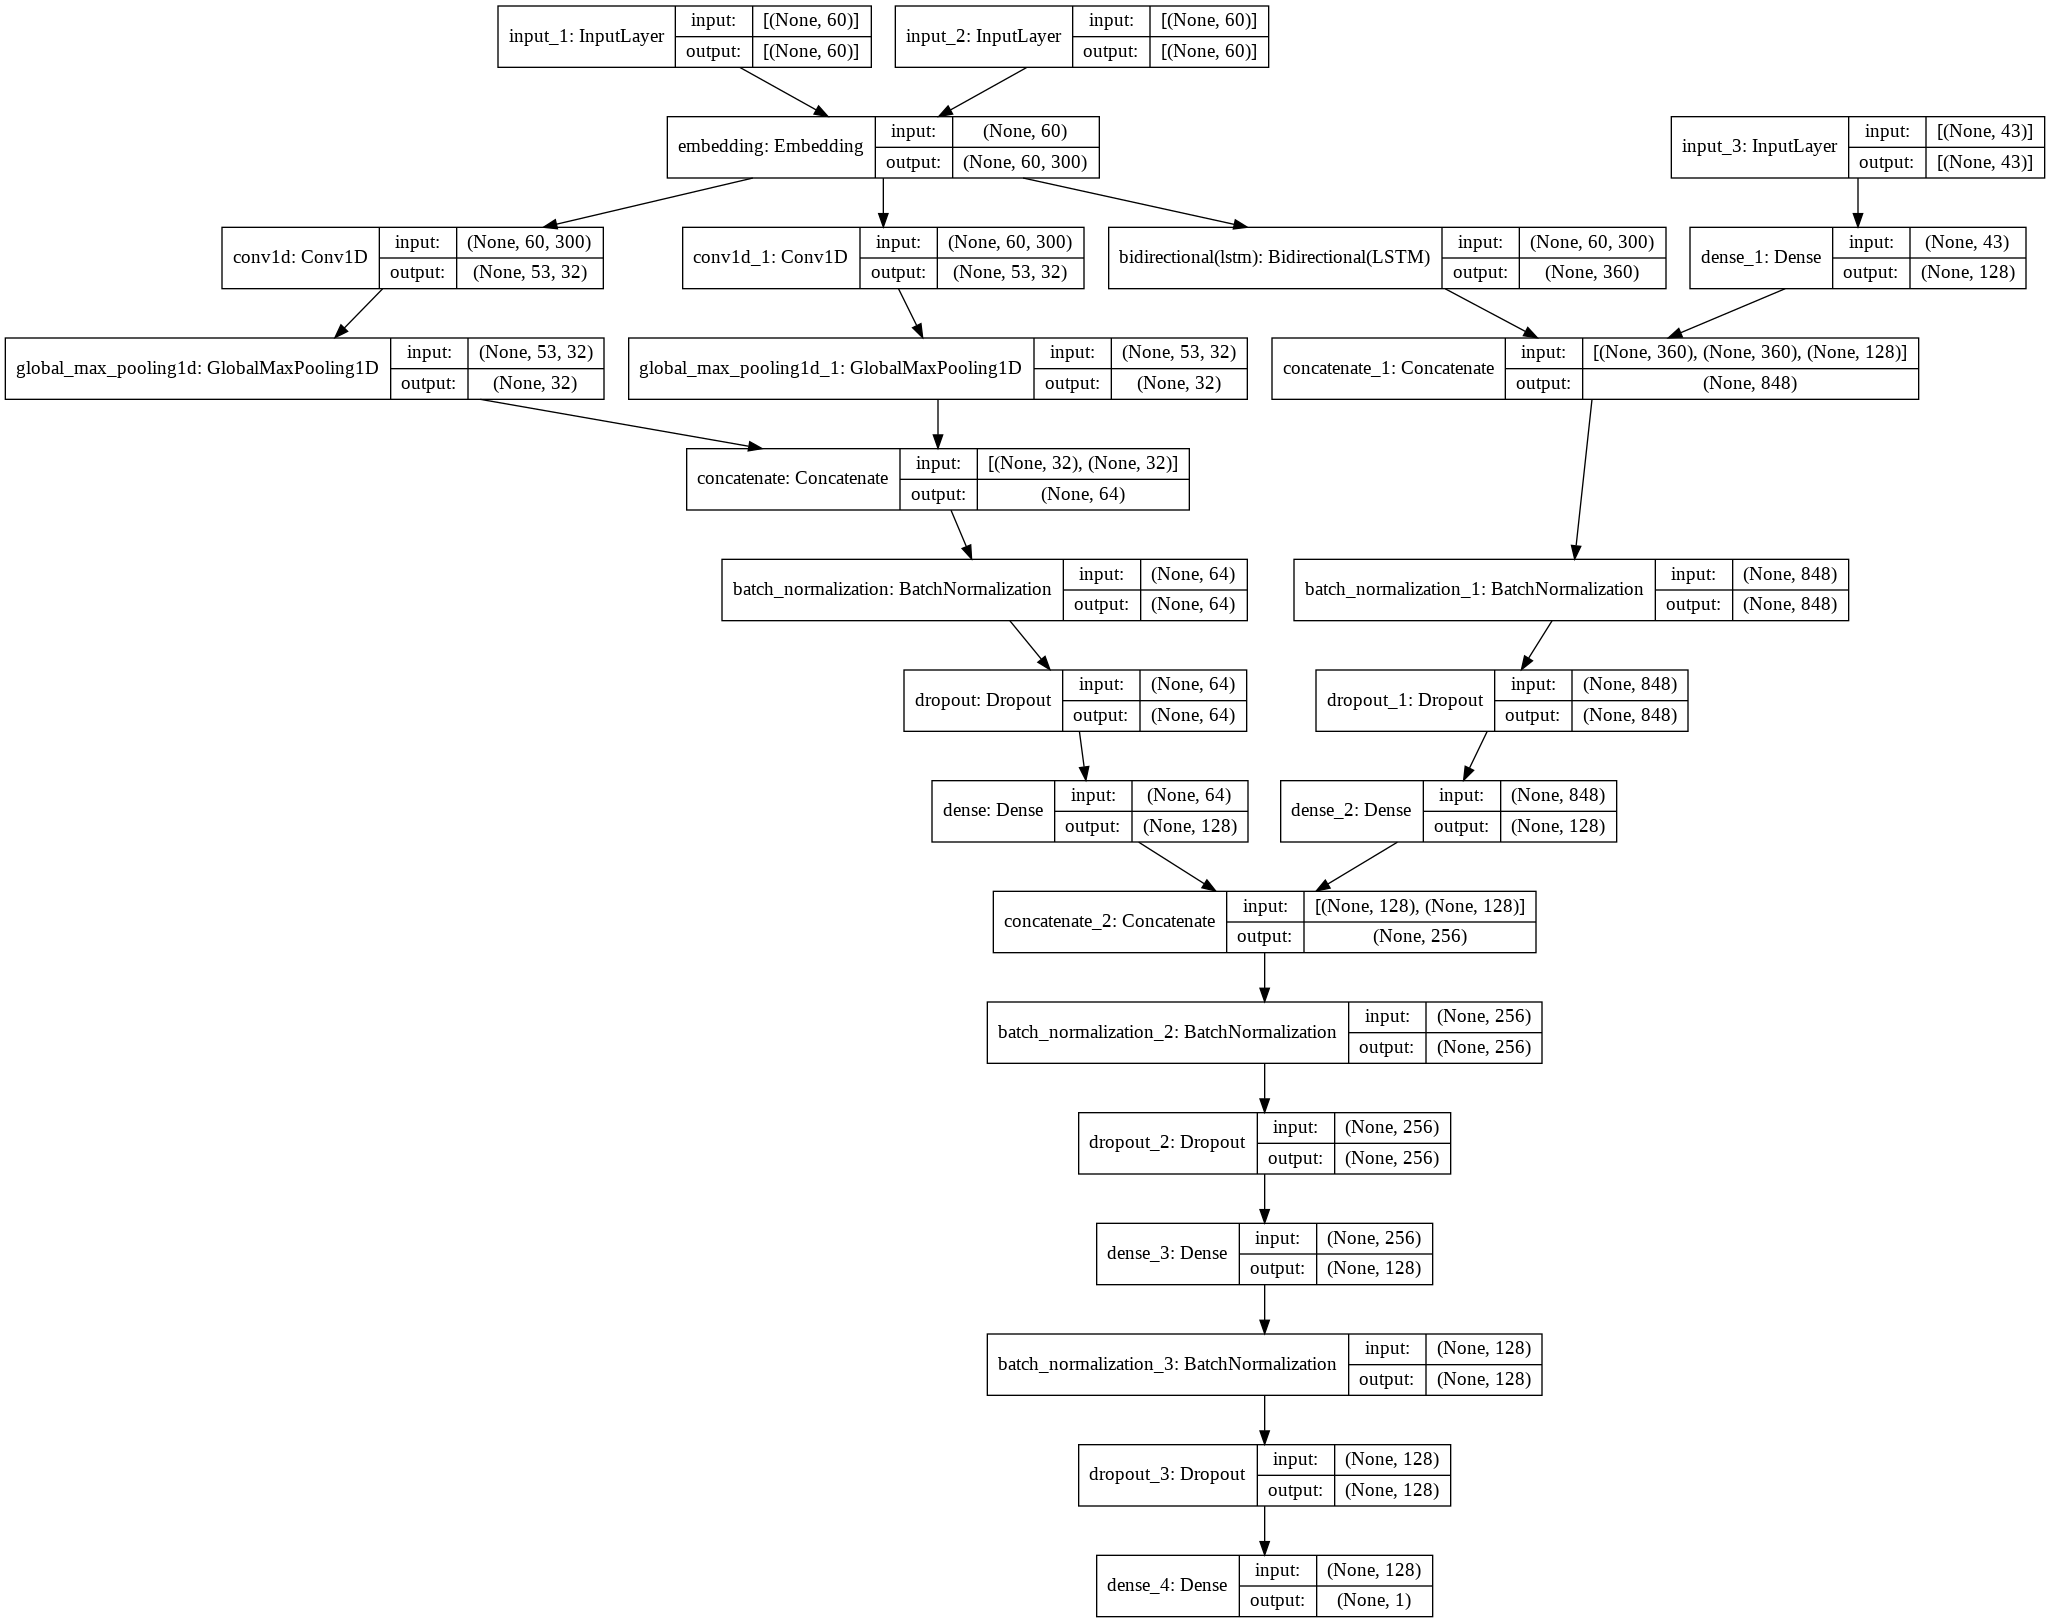

In [53]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = 'lstm_featured_new_file_2.h5' 
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [56]:
hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train, \
        validation_data=([data_1_val, data_2_val, leaks_val], labels_val), \
        epochs=3,  batch_size = 2048, shuffle=True, \
        callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path) 
bst_val_score = min(hist.history['val_loss'])

Epoch 1/3
356/356 [==============================] - 372s 1s/step - loss: 0.3851 - acc: 0.8125 - val_loss: 0.2722 - val_acc: 0.8720
Epoch 2/3
356/356 [==============================] - 364s 1s/step - loss: 0.2742 - acc: 0.8722 - val_loss: 0.2498 - val_acc: 0.8859
Epoch 3/3
356/356 [==============================] - 365s 1s/step - loss: 0.2575 - acc: 0.8812 - val_loss: 0.2427 - val_acc: 0.8885


In [57]:
model.save('/content/drive/MyDrive/Project/model.h5')

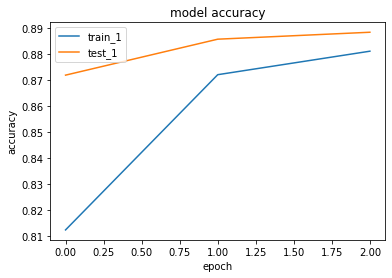

In [58]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_1', 'test_1'], loc='upper left')
plt.show()

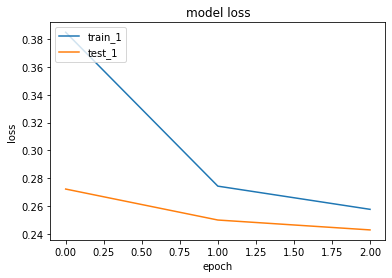

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_1', 'test_1'], loc='upper left')
plt.show()

In [ ]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/Project/new_test_model_7:30pm.h5')

In [60]:
model.evaluate([data_1_val,data_2_val,leaks_val],y = labels_val,verbose=1)

2527/2527 [==============================] - 152s 60ms/step - loss: 0.2427 - acc: 0.8885


[0.24272093176841736, 0.8885302543640137]

In [1]:
# print('Predict test data')

# preds = model.predict([data_1_val,data_2_val,leaks_val], batch_size=8192, verbose=1,)
# preds += model.predict([data_2_val, data_1_val, leaks_val], batch_size=8192, verbose=1)
# preds /= 2

In [2]:
# for i in range(0,len(preds)):
#   if preds[i]>=0.5:
#     preds[i]=1
#   else:
#     preds[i]=0

In [3]:
# df_train['preds_value'] = preds

In [4]:
# df_train.head()

In [5]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt


In [6]:
# cf_matrix = confusion_matrix(df_train['is_duplicate'], df_train['preds_value'])
# print(cf_matrix)

In [7]:
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
# plt.subplots(figsize=(10,8))
# sns.set(font_scale=2.0)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [8]:
# result = []
# for i,j,k in zip(df_test.question1.values,df_test.question2.values,preds.ravel()):
#   result.append([i,j,k])

In [9]:
# df = pd.DataFrame(data=result,columns=['question1','question2','predict'])

In [10]:
# df.head()

In [11]:
# df.to_csv('predicted.csv')

In [12]:
# msr_test = pd.read_table(r'/content/drive/MyDrive/msr_paraphrase_test.txt',error_bad_lines=False)

In [13]:
# msr_test.head()

In [14]:
# msr_test.to_csv('msr_paraphrase_test.csv')